### Load libraries

In [1]:
# Basic libraries
import os, sys
from datetime import date
import pandas as pd 
import numpy as np 
import scanpy as sc 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# DGE analysis
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import decoupler 

# GO analysis
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import gseapy as gp
from gseapy.plot import gseaplot

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

<i><b> Set the home directory </b></i>

In [2]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

<i><b> Set the container image </b></i>

In [3]:
# Container used for this analysis can be found here : cokorac/cs-core-image-amd64:dev
day = date.today()
print('The last use of the container:', day)

The last use of the container: 2025-06-20


### Load the data

In [4]:
# Load the data
adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_clustered.h5ad")
adata.shape

(113298, 10828)

In [5]:
# Ensure that categories are strings
adata.obs['leiden_subclustered_G1_RG_ss']  = adata.obs['leiden_subclustered_G1_RG_ss'].astype(str)
adata.obs['X_leiden_harmony']  = adata.obs['X_leiden_harmony'].astype(str)

In [6]:
# Map original clusters to the new cluster category 
adata.obs['leiden_subclustered_G1_RG_ss'] = adata.obs['leiden_subclustered_G1_RG_ss'].mask(adata.obs['leiden_subclustered_G1_RG_ss'] == "", adata.obs['X_leiden_harmony'])

### Pseudobulking

In [7]:
# Remove clusters of non-neuronal lineages
adata_neuronal = adata[~adata.obs['leiden_subclustered_G1_RG_ss'].isin(['Microglia', 'Endothelial', 'IN1', 'IN2'])].copy()
adata_neuronal.shape

(96849, 10828)

In [8]:
# Group neuronal clusters together
adata_neuronal.obs["leiden_subclustered_G1_RG_ss"] = adata.obs["leiden_subclustered_G1_RG_ss"].astype('category')

cluster_combination = {'N1':'N', 
                       'N2':'N',
                       'N3':'N',
                       'N4':'N', 
                       'N5': 'N',
                       'N6':'N', 
                       'N7':'N', 
                       'G1 IPs': 'G1 IPs', 
                       'G2M-S Pgs':'G2M-S Pgs', 
                       'human_ncx_RG 2':'human_ncx_RG_2', 
                       'human_ncx_RG 1': 'human_ncx_RG_1', 
                       'human_ncx_RG 3': 'human_ncx_RG_3', 
                       'mouse_dg_RG 1': 'mouse_dg_RG_1', 
                       'mouse_dg_RG 2': 'mouse_dg_RG_2', 
                       'mouse_ncx_RG': 'mouse_ncx_RG', 
                       'Glia':'Glia'}

default_name = "unknown"

adata_neuronal.obs["leiden_subclustered_G1_RG_ss_merged"] = adata_neuronal.obs["leiden_subclustered_G1_RG_ss"].map(cluster_combination).fillna(default_name)
adata_neuronal.obs["leiden_subclustered_G1_RG_ss_merged"] = adata_neuronal.obs["leiden_subclustered_G1_RG_ss_merged"].astype('category') 

In [9]:
# Switch to raw counts
adata_neuronal.X = adata_neuronal.layers['counts'].copy()
# Round the numbers 
adata_neuronal.X = np.round(adata_neuronal.X)

In [10]:
# Generate pseudobulk counts
pdata = decoupler.get_pseudobulk(
    adata_neuronal,
    sample_col='sample_id',
    groups_col='leiden_subclustered_G1_RG_ss_merged',
    layer='counts',
    mode= 'sum',
    min_cells=10,
    min_counts=10000
)

In [11]:
# Save pseudobulk anndata
pdata.write_h5ad('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_psedobulk.h5ad')

### DGE analysis 

In [12]:
# Subset to clusters of interest
brg_hs_ncx_mm_ncx = pdata[pdata.obs['leiden_subclustered_G1_RG_ss_merged'].isin(['human_ncx_RG_2', 'mouse_ncx_RG'])].copy()

In [13]:
# Store raw counts in layers
brg_hs_ncx_mm_ncx.layers['counts'] = brg_hs_ncx_mm_ncx.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(brg_hs_ncx_mm_ncx, target_sum=1e6, exclude_highly_expressed=True)
brg_hs_ncx_mm_ncx.layers['normalized'] = brg_hs_ncx_mm_ncx.X.copy()
sc.pp.log1p(brg_hs_ncx_mm_ncx)
brg_hs_ncx_mm_ncx.layers['log-normalized'] = brg_hs_ncx_mm_ncx.X.copy()
sc.pp.scale(brg_hs_ncx_mm_ncx, max_value=10)
brg_hs_ncx_mm_ncx.layers['normalized-scaled'] = brg_hs_ncx_mm_ncx.X.copy()

AnnData object with n_obs × n_vars = 30 × 8780
    obs: 'sample_id', 'leiden_subclustered_G1_RG_ss_merged', 'dataset_of_origin', 'species', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p'
    layers: 'psbulk_props', 'counts', 'normalized', 'log-normalized', 'normalized-scaled'

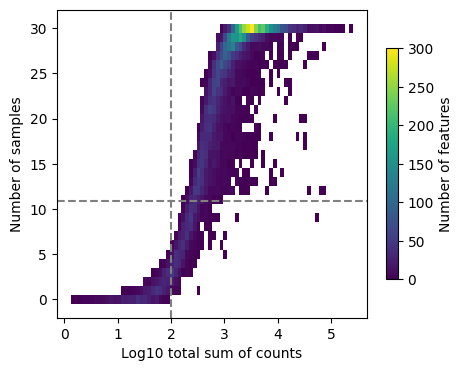

In [14]:
# Keep only sufficiently abundant genes
brg_hs_ncx_mm_ncx.X = brg_hs_ncx_mm_ncx.layers['normalized'].copy()
decoupler.plot_filter_by_expr(brg_hs_ncx_mm_ncx, group='leiden_subclustered_G1_RG_ss_merged', min_count=10, min_total_count=100, min_prop = 0.7)
genes = decoupler.filter_by_expr(brg_hs_ncx_mm_ncx, group='leiden_subclustered_G1_RG_ss_merged', min_count= 10, min_total_count=100)
brg_hs_ncx_mm_ncx_ss = brg_hs_ncx_mm_ncx[:, genes].copy()
brg_hs_ncx_mm_ncx_ss

In [15]:
# Prepare the DeSeq2 format
brg_hs_ncx_mm_ncx_ss.X = brg_hs_ncx_mm_ncx_ss.layers['counts'].copy()

dds = DeseqDataSet(
    adata = brg_hs_ncx_mm_ncx_ss,    
    design_factors= ['leiden_subclustered_G1_RG_ss_merged'],
    ref_level=['leiden_subclustered_G1_RG_ss_merged', 'human_ncx_RG_2'],
    refit_cooks=True)

/tmp/ipykernel_2760355/3157205112.py:4: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
/usr/local/lib/python3.10/dist-packages/pydeseq2/dds.py:270: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [16]:
# Perform deseq2
dds.deseq2() 

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.12 seconds.

Fitting dispersion trend curve...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 4.08 seconds.

Fitting LFCs...
... done in 2.44 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 3 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [17]:
# Output results
stat_res = DeseqStats(dds, contrast=['leiden-subclustered-G1-RG-ss-merged', 'human-ncx-RG-2', 'mouse-ncx-RG'])
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: leiden-subclustered-G1-RG-ss-merged human-ncx-RG-2 vs mouse-ncx-RG
         baseMean  log2FoldChange     lfcSE       stat        pvalue  \
AAAS     7.998471        0.697473  0.219375   3.179359  1.476011e-03   
AACS     6.093438        0.226525  0.280801   0.806709  4.198339e-01   
AAGAB    5.754626       -1.630067  0.274304  -5.942556  2.806122e-09   
AAK1     7.967079        4.374958  0.399367  10.954740  6.305909e-28   
AAMDC   17.863582        0.293335  0.205768   1.425560  1.539954e-01   
...           ...             ...       ...        ...           ...   
ZXDC     3.872579        1.673873  0.327906   5.104727  3.312726e-07   
ZYG11B  15.260423        1.053755  0.163181   6.457576  1.063930e-10   
ZYX     12.693829       -0.081725  0.199512  -0.409625  6.820811e-01   
ZZEF1    4.901410       -0.023401  0.292025  -0.080132  9.361321e-01   
ZZZ3    20.444767        0.247018  0.196316   1.258264  2.082963e-01   

                padj  
AAAS   

... done in 1.01 seconds.



In [18]:
# Output the dataframe
results_df = stat_res.results_df
# Reindex the dataframe
results_df_bRG = results_df.copy()
results_df_bRG.reset_index(inplace=True)
results_df_bRG.rename(columns ={'index':'gene_name'}, inplace = True)

In [19]:
# Convert to -log10padj
results_df['log_10_padj'] = -np.log10(results_df['padj'])
# Cap the -log10padj
cap = 10
results_df['log_10_padj_capped'] = np.where(results_df['log_10_padj']>cap, cap, results_df['log_10_padj'])

In [20]:
# Filter the p adjusted 
DEGs_bRG = results_df[results_df['padj'] < 0.05]
# Filtr the log2FC
degs_human_up = DEGs_bRG[DEGs_bRG['log2FoldChange'] > 1]
degs_human_down = DEGs_bRG[DEGs_bRG['log2FoldChange'] < -1]
# Print the number of up and down-regulated genes
print(len(degs_human_up))
print(len(degs_human_down))

2845
1104


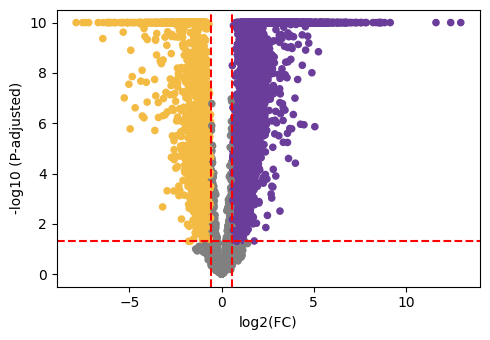

In [21]:
%run -i '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scmorpho_final/helper_functions/Volcano_plot.py'
# Plot the volcano plot
volcano_plot(df = results_df, df_up=degs_human_up, df_down=degs_human_down)
plt.grid(False)
plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/degs/hs_ncx_rg2_vs_mm_dg_rg_1/Volcano_plot_hs_ncx_rg2_vs_mm_dg_rg_1.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

### Save DGE results

In [22]:
# Save the background genes 
results_df.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_ncx_rg/background_genes_hs_ncx_rg2_vs_mm_ncx_rg.csv')
results_df.shape

(8780, 8)

In [23]:
 # Save the up-regulated genes
degs_human_up.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_ncx_rg/DEGs_up_hs_ncx_rg2_vs_mm_ncx_rg.csv')
print(len(degs_human_up))
# Save the down-regulated genes
degs_human_down.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_ncx_rg/DEGs_down_hs_ncx_rg2_vs_mm_ncx_rg.csv')
print(len(degs_human_down))

2845
1104


### GO analysis

In [24]:
# Convert background genes to a list
background_list = results_df.index.tolist()
# Convert up-regulated genes to a list
degs_human_up_list = degs_human_up.index.tolist()
# Convert down-regulated genes to a list
degs_human_down_list = degs_human_down.index.tolist()

In [25]:
# Load the ontology lists
ontology_list = ['/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c5.go.bp.v2023.2.Hs.symbols.gmt', 
                 #'/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c5.go.cc.v2023.2.Hs.symbols.gmt', 
                 #'/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c5.go.mf.v2023.2.Hs.symbols.gmt',
                 #'/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c2.cp.v2023.2.Hs.symbols.gmt'
                 ]

In [26]:
# Perform GO analysis
# Up-regulated in human Ncx bRG 1 vs mouse DG bRG 1
FAM107A_RG_hsNcx_vs_mmNcx_up = gp.enrichr(gene_list= degs_human_up_list, 
                                  gene_sets= ontology_list, 
                                  organism='Human', 
                                  cutoff=0.5, 
                                  background = background_list,
                                  no_plot= True)

FAM107A_RG_hsNcx_vs_mmNcx_up_df = pd.DataFrame(FAM107A_RG_hsNcx_vs_mmNcx_up.results)

# Down-regulated in human Ncx bRG 1 vs mouse DG bRG 1
FAM107A_RG_hsNcx_vs_mmNcx_down = gp.enrichr(gene_list= degs_human_down_list, 
                                    gene_sets= ontology_list, 
                                    organism='Human', 
                                    cutoff=0.5, 
                                    background = background_list,
                                    no_plot= True)

FAM107A_RG_hsNcx_vs_mmNcx_down_df = pd.DataFrame(FAM107A_RG_hsNcx_vs_mmNcx_down.results)

In [27]:
 # Save the files
# up-regulated GO terms
FAM107A_RG_hsNcx_vs_mmNcx_up_df.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/GO/hs_ncx_rg2_vs_mm_ncx_rg/GO_hs_ncx_rg2_vs_mm_ncx_rg_1_UP_enrichment.csv')
# down-regulated GO terms
FAM107A_RG_hsNcx_vs_mmNcx_down_df.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/GO/hs_ncx_rg2_vs_mm_ncx_rg/GO_hs_ncx_rg2_vs_mm_ncx_rg_1_DOWN_enrichment.csv')

In [28]:
# Define the 'Gene ontology type' 
FAM107A_RG_hsNcx_vs_mmNcx_up_df['Ontology_type'] = FAM107A_RG_hsNcx_vs_mmNcx_up_df.Gene_set.str[:8]
FAM107A_RG_hsNcx_vs_mmNcx_down_df['Ontology_type'] = FAM107A_RG_hsNcx_vs_mmNcx_down_df.Gene_set.str[:8]

In [29]:
# Add the 'regulation' column
FAM107A_RG_hsNcx_vs_mmNcx_up_df['regulation'] = 'up-regulated'
FAM107A_RG_hsNcx_vs_mmNcx_down_df['regulation'] = 'down-regulated'

In [30]:
# Remove the insignificant terms
FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig = FAM107A_RG_hsNcx_vs_mmNcx_up_df[FAM107A_RG_hsNcx_vs_mmNcx_up_df['Adjusted P-value'] < 0.05]
FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig = FAM107A_RG_hsNcx_vs_mmNcx_down_df[FAM107A_RG_hsNcx_vs_mmNcx_down_df['Adjusted P-value'] < 0.05]

print('Total number of significantly up-regulated GO terms:', len(FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig))
print('Total number of significantly down-regulated GO terms:', len(FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig))

Total number of significantly up-regulated GO terms: 48
Total number of significantly down-regulated GO terms: 15


In [31]:
# Sort based on the Combined Score
# up-regulated GO terms
FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig = FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig.sort_values(by = 'Combined Score', ascending=False)
# down-regulated GO terms
FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig = FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig.sort_values(by = 'Combined Score', ascending=False)

In [32]:
# Clean the 'Term' column 
# up-regulated GO terms
FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig['Term_clean'] = FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig.Term.apply(lambda x: x[5:])
FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig["Term_clean"] = FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig["Term_clean"].str.replace("_", " ").str.capitalize()
# down-regulated GO terms
FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig['Term_clean'] = FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig.Term.apply(lambda x: x[5:])
FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig["Term_clean"] = FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig["Term_clean"].str.replace("_", " ").str.capitalize()

In [33]:
 # Subset the list of 'up-regulated' GO terms to terms of interest
# up-regulated terms
terms_of_interest_up = ['Neurogenesis', 'Generation of neurons', 'Neuron development', 'Positive regulation of gtpase activity', 
                        'Cell part morphogenesis', 'Synaptic signaling', 'Cell cell adhesion']

FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig_ss = FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig[FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig['Term_clean'].isin(terms_of_interest_up)]

# down-regulated terms
terms_of_interest_down = ['Rna processing', 'Ribosome biogenesis', 'Dna metabolic process', 'Cell cycle dna replication']

FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig_ss = FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig[FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig['Term_clean'].isin(terms_of_interest_down)]

In [34]:
# Concatenate 
FAM107A_RG_hsNcx_vs_mmNcx_combined = pd.concat([FAM107A_RG_hsNcx_vs_mmNcx_up_df_sig_ss, FAM107A_RG_hsNcx_vs_mmNcx_down_df_sig_ss])

# Add negative 'Combined Scores' to down-regulated GO terms
FAM107A_RG_hsNcx_vs_mmNcx_combined['Modified Combined Score'] = FAM107A_RG_hsNcx_vs_mmNcx_combined.apply(lambda row: -row['Combined Score'] if 
                                                                                         row['regulation'] == 'down-regulated' else row['Combined Score'], axis = 1)

# Convert the Adjusted P-value to -log10 format
FAM107A_RG_hsNcx_vs_mmNcx_combined['-log10(Adjusted P-value)'] = -np.log10(FAM107A_RG_hsNcx_vs_mmNcx_combined['Adjusted P-value'])

In [35]:
# Sort values based on 'Modified Combined Score'
FAM107A_RG_hsNcx_vs_mmNcx_combined = FAM107A_RG_hsNcx_vs_mmNcx_combined.sort_values(by='Modified Combined Score', ascending=False)

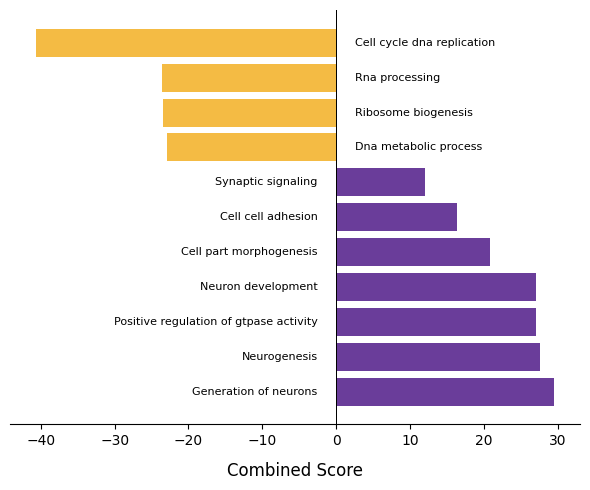

In [36]:
%run -i '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/helper_functions/GO_barplot.py'
# Plot
GO_barplot(FAM107A_RG_hsNcx_vs_mmNcx_combined)
# Save the plot
#fig = plt.gcf()
plt.grid(False)
plt.tight_layout()
plt.savefig("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/GO/hs_ncx_rg2_vs_mm_ncx_rg/Barplot_hs_ncx_rg2_vs_mm_ncx_rg.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()